In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from functools import reduce
import operator

from common_plotting import read_data
from common_analysis import rel_data_cut_index_last, combine_stds_sum, display_full_df
from common_analysis_dcv import (analyse_dcv_absolute, analyse_dcv_relative, analyse_dcv_k182, analyse_dcv_k182_for_other_reference, add_dut_neg_and_pos_group)

plt.rcParams["figure.figsize"] = (10,4)
plt.rc('font', size=14)

# 10 V DC

## 3458A measurements

In [68]:
duts = [
'2-F7001-bat-alm-971756543',
'2-LTZ1000-1-branadic',
'2-LTZ1000-2-branadic',
'2-LTZ1000-3-branadic',
'3-LTZ1000-1-branadic',
'3-LTZ1000-2-branadic',
'3-LTZ10`00-3-branadic',
'3a-F7001-bat-alm-971756543',
'F7001-alm-971756543',
'F7001-bat-alm-971756543',
'LTZ1000-1-branadic',
'LTZ1000-2-branadic',
'LTZ1000-3-branadic',
'V2720GS+10V',
'V2720GS-10V',
]
data_both_polarities_list = []
summed_up_list = []
for dut in duts:
    data = pd.read_csv(f'MMM2023/12112023_dcv_{dut}.csv', sep=';', parse_dates=['%date-time'])
    data.rename(columns={f' {dut} [V]': 'dut output [V]'}, inplace=True)
    pol_counts = data.groupby(' Polarity (+/-)').agg({'%date-time': ['min', 'count']})
    min_idx = pol_counts[('%date-time', 'count')].idxmin()
    min_count = pol_counts.loc[min_idx][('%date-time', 'count')]
    min_data = data[data[' Polarity (+/-)'] == min_idx]
    if pol_counts.loc[min_idx][('%date-time', 'min')] < pol_counts[pol_counts.index != min_idx][('%date-time', 'min')].min():
        cut_data = data[data[' Polarity (+/-)'] != min_idx].head(min_count)
    else:
        cut_data = data[data[' Polarity (+/-)'] != min_idx].tail(min_count)
    equalized_data = pd.concat([min_data, cut_data])
    equalized_data['dut'] = dut
    data_both_polarities = equalized_data.groupby(['dut', ' Polarity (+/-)']).agg({'dut output [V]': ['mean', 'std', 'sem', 'count'], ' TMP112 [°C]': ['mean'], 'SHT25 [°C]': ['mean'], 'SHT25 [%rH]': ['mean'], 'MS5611 [°C]': ['mean'], 'MS5611 [hPa]': ['mean']})
    data_both_polarities_list.append(data_both_polarities)
    data_to_sum_up = data_both_polarities.reset_index()
    data_to_sum_up['sign_corrected_voltage'] = data_to_sum_up[('dut output [V]', 'mean')] * data_to_sum_up[' Polarity (+/-)'].apply(lambda x: -1 if x == '-' else 1)
    summed_up_data = data_to_sum_up.groupby('dut').agg({('sign_corrected_voltage', ''): ['mean'], ('dut output [V]', 'std'): combine_stds_sum, ('dut output [V]', 'sem'): combine_stds_sum, ('dut output [V]', 'count'): np.sum, (' TMP112 [°C]', 'mean'): ['mean'], ('SHT25 [°C]', 'mean'): ['mean'], ('SHT25 [%rH]', 'mean'): ['mean'], ('MS5611 [°C]', 'mean'): ['mean'], ('MS5611 [hPa]', 'mean'): ['mean']})
    summed_up_list.append(summed_up_data)
data_both_polarities = pd.concat(data_both_polarities_list)
summed_up_data = pd.concat(summed_up_list)
summed_up_data.columns = ['dut output [V] [mean]', 'dut ouptut [V] [std]', 'dut output [V] [sem]', 'dut output [V] [count]', ' TMP112 [°C]', 'SHT25 [°C]', 'SHT25 [%rH]', 'MS5611 [°C]', 'MS5611 [hPa]']
summed_up_data['corrected_output'] = summed_up_data['dut output [V] [mean]'] * 0.999993358
display(data_both_polarities)
display(summed_up_data)

dut output [V]                \
                                                     mean           std   
dut                         Polarity (+/-)                                
2-F7001-bat-alm-971756543  +                     9.999993  2.604091e-07   
                           -                    -9.999994  1.674883e-07   
2-LTZ1000-1-branadic       +                    10.008728  6.013396e-07   
                           -                   -10.008728  2.885776e-07   
2-LTZ1000-2-branadic       +                    10.008836  2.828056e-07   
                           -                   -10.008837  3.276794e-07   
2-LTZ1000-3-branadic       +                     9.989968  4.967027e-07   
                           -                    -9.989970  1.690840e-07   
3-LTZ1000-1-branadic       +                    10.008725  2.435290e-07   
                           -                   -10.008727  1.773597e-07   
3-LTZ1000-2-branadic       +                    10.008837  2.834778e-07   
                           -                   -10.008838  3.211043e-07   
3-LTZ1000-3-branadic       +                     9.989967  1.422851e-07   
                           -                    -9.989970  2.574933e-07   
3a-F7001-bat-alm-971756543 +                     9.999993  1.810384e-07   
                           -                    -9.999995  1.359728e-07   
F7001-alm-971756543        +                     9.999991  1.392824e-07   
                           -                    -9.999992  1.873989e-07   
F7001-bat-alm-971756543    +                     9.999992  1.837015e-07   
                           -                    -9.999993  1.199166e-07   
LTZ1000-1-branadic         +                    10.008723  7.487463e-07   
                           -                   -10.008726  2.253016e-07   
LTZ1000-2-branadic         +                    10.008830  9.045936e-07   
                           -                   -10.008832  2.446145e-07   
LTZ1000-3-branadic         +                     9.989968  1.506652e-07   
                           -                    -9.989970  1.823184e-07   
V2720GS+10V                +                    10.000113  2.821938e-07   
                           -                   -10.000114  2.447550e-07   
V2720GS-10V                +                   -10.000028  4.344455e-07   
                           -                    10.000026  3.096207e-07   

                                                                TMP112 [°C]  \
                                                     sem count         mean   
dut                         Polarity (+/-)                                    
2-F7001-bat-alm-971756543  +                4.603426e-08    32    25.226562   
                           -                2.960802e-08    32    25.107422   
2-LTZ1000-1-branadic       +                1.063028e-07    32    25.277344   
                           -                5.101379e-08    32    25.138672   
2-LTZ1000-2-branadic       +                4.999345e-08    32    25.136719   
                           -                5.792608e-08    32    25.017578   
2-LTZ1000-3-branadic       +                8.780547e-08    32    24.953125   
                           -                2.989012e-08    32    25.160156   
3-LTZ1000-1-branadic       +                4.305024e-08    32    25.226562   
                           -                3.135306e-08    32    25.167969   
3-LTZ1000-2-branadic       +                5.011227e-08    32    25.361328   
                           -                5.676375e-08    32    25.404297   
3-LTZ1000-3-branadic       +                2.515270e-08    32    25.216797   
                           -                4.551882e-08    32    25.384766   
3a-F7001-bat-alm-971756543 +                3.200337e-08    32    25.339844   
                           -                2.403683e-08    32    25.292969   
F7001-alm-971756543        +                3.482060e-08    16    

,dut output [V] [mean],dut ouptut [V] [std],dut output [V] [sem],dut output [V] [count],TMP112 [°C],SHT25 [°C],SHT25 [%rH],MS5611 [°C],MS5611 [hPa],corrected_output
dut,,,,,,,,,,
2-F7001-bat-alm-971756543,9.999994,2.189352e-07,3.870264e-08,64,25.166992,25.116281,33.368906,25.335437,954.877062,9.999927
2-LTZ1000-1-branadic,10.008728,4.716388e-07,8.337475e-08,64,25.208008,25.279453,33.398125,25.455297,955.041906,10.008661
2-LTZ1000-2-branadic,10.008836,3.060660e-07,5.410534e-08,64,25.077148,25.206750,33.521250,25.421312,954.941516,10.008770
2-LTZ1000-3-branadic,9.989969,3.710142e-07,6.558666e-08,64,25.056641,25.100844,33.623750,25.372109,954.886406,9.989902
3-LTZ1000-1-branadic,10.008726,2.130291e-07,3.765858e-08,64,25.197266,25.251766,33.512344,25.449328,955.017719,10.008659
3-LTZ1000-2-branadic,10.008837,3.028759e-07,5.354140e-08,64,25.382812,25.389437,33.560469,25.519781,955.049125,10.008771
3-LTZ1000-3-branadic,9.989968,2.080239e-07,3.677378e-08,64,25.300781,25.284125,33.784219,25.525266,955.113437,9.989902
3a-F7001-bat-alm-971756543,9.999994,1.600992e-07,2.830181e-08,64,25.316406,25.368156,33.947812,25.597031,955.199125,9.999928
F7001-alm-971756543,9.999992,1.651029e-07,4.127572e-08,32,24.992188,25.290719,32.724063,25.497406,955.080969,9.999925


Drift of F7001-alm compared to MM2022 value as calculated based on 3458A measurements and 3458A drift estimated by branadic

In [46]:
(9.999928 - 9.999935) * 1e6 / 10

-0.7000000000090267

## S7081 measurements

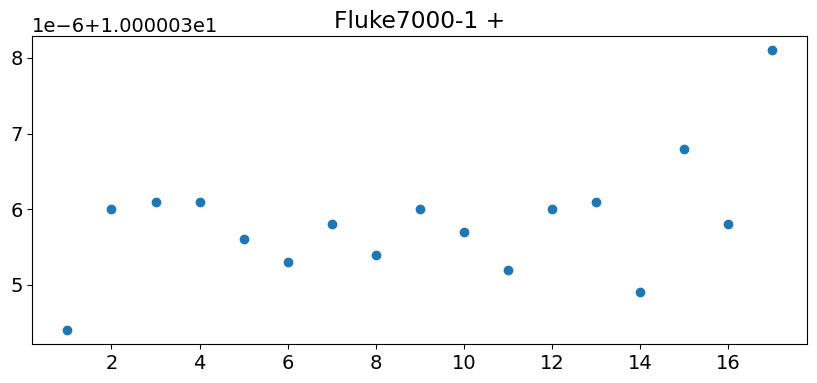

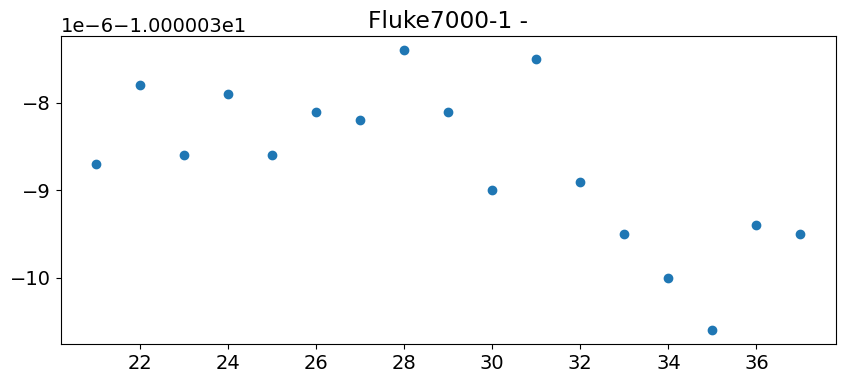

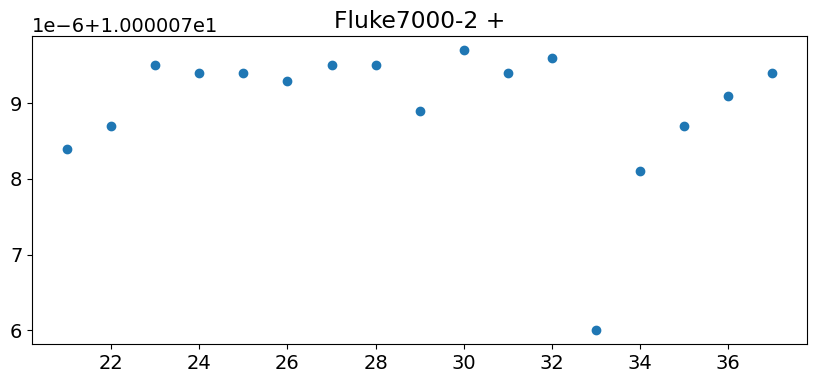

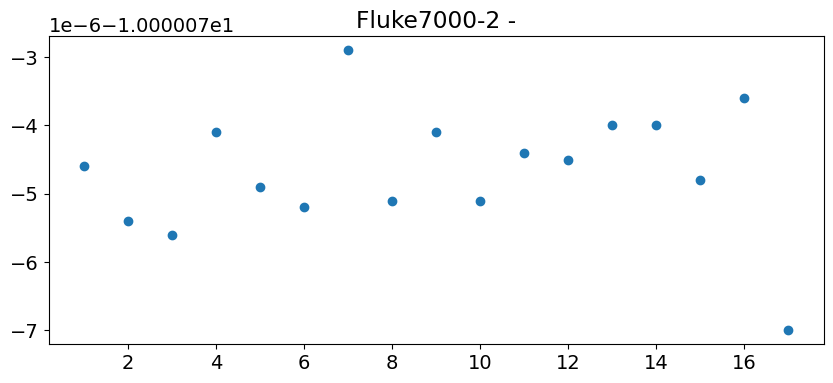

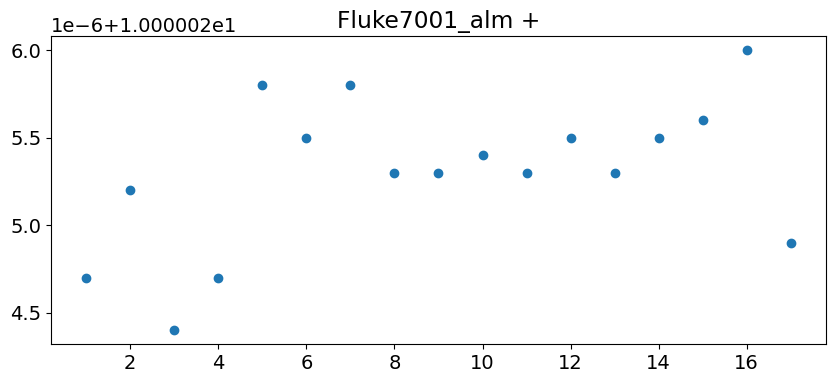

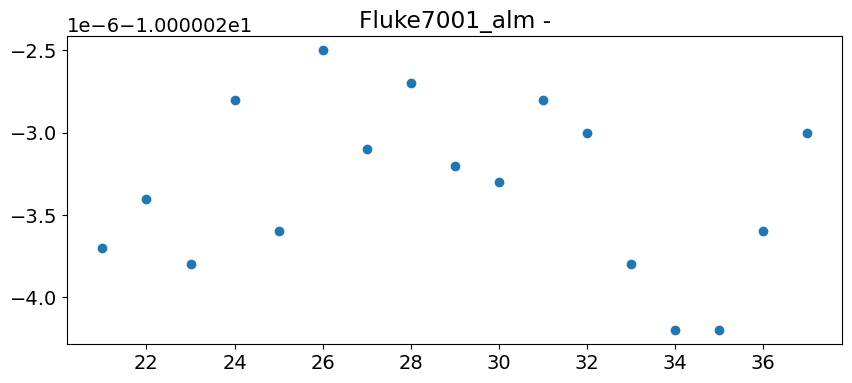

S7081 [V]                                    \
                                    mean           std           sem count   
dut            Polarity (+/-)                                                
Fluke7000-1   +                10.000036  8.000460e-07  1.940396e-07    17   
              -               -10.000039  8.933578e-07  2.166711e-07    17   
Fluke7000-2   +                10.000079  8.905963e-07  2.160013e-07    17   
              -               -10.000075  9.178379e-07  2.226084e-07    17   
Fluke7001_alm +                10.000025  4.264249e-07  1.034232e-07    17   
              -               -10.000023  5.110543e-07  1.239489e-07    17   

                              TMP112 [°C] SHT25 [°C] SHT25 [%rH] MS5611 [°C]  \
                                     mean       mean        mean        mean   
dut            Polarity (+/-)                                                  
Fluke7000-1   +                 23.238971  23.346294   57.798235   23.869353   
              -                 23.220588  23.306000   57.841765   23.866647   
Fluke7000-2   +                 23.275735  23.299059   57.783529   23.841765   
              -                 23.242647  23.329235   57.740588   23.869000   
Fluke7001_alm +                 23.264706  23.263824   57.836471   23.878235   
              -                 23.272059  23.391235   57.829412   23.901706   

                              MS5611 [hPa]  
                                      mean  
dut            Polarity (+/-)               
Fluke7000-1   +                 982.445882  
              -                 982.316176  
Fluke7000-2   +                 981.992882  
              -                 982.120412  
Fluke7001_alm +                 982.286000  
              -                 982.511235

,dut output [V] [mean],dut ouptut [V] [std],dut output [V] [sem],dut output [V] [count],TMP112 [°C],SHT25 [°C],SHT25 [%rH],MS5611 [°C],MS5611 [hPa]
dut,,,,,,,,,
Fluke7000-1,10.000037,8.479864e-07,2.056669e-07,34,23.229779,23.326147,57.820000,23.868000,982.381029
Fluke7000-2,10.000077,9.043197e-07,2.193297e-07,34,23.259191,23.314147,57.762059,23.855382,982.056647
Fluke7001_alm,10.000024,4.706457e-07,1.141483e-07,34,23.268382,23.327529,57.832941,23.889971,982.398618


In [79]:
duts = [
'Fluke7000-1',
'Fluke7000-2',
'Fluke7001_alm',
]
data_both_polarities_list = []
summed_up_list = []
for dut in duts:
    data = pd.read_csv(f'MMM2023/12112023_{dut}_S7081.csv', sep=';', parse_dates=['%date-time'])
    data[' Polarity (+/-)'] = data['S7081 [V]'].apply(lambda x: '+' if x > 0 else '-')
    pol_counts = data.groupby(' Polarity (+/-)').agg({'%date-time': ['min', 'count']})
    min_idx = pol_counts[('%date-time', 'count')].idxmin()
    min_data = data[data[' Polarity (+/-)'] == min_idx].iloc[1:18]
    cut_data = data[data[' Polarity (+/-)'] != min_idx].iloc[1:18]
    equalized_data = pd.concat([min_data, cut_data])
    min_data['S7081 [V]'].plot(style="o")
    plt.title(f"{dut} {min_data[' Polarity (+/-)'].iloc[0]}")
    plt.show()
    cut_data['S7081 [V]'].plot(style="o")
    plt.title(f"{dut} {cut_data[' Polarity (+/-)'].iloc[0]}")
    plt.show()
    equalized_data['dut'] = dut
    data_both_polarities = equalized_data.groupby(['dut', ' Polarity (+/-)']).agg({'S7081 [V]': ['mean', 'std', 'sem', 'count'], 'TMP112 [°C]': ['mean'], 'SHT25 [°C]': ['mean'], 'SHT25 [%rH]': ['mean'], 'MS5611 [°C]': ['mean'], 'MS5611 [hPa]': ['mean']})
    data_both_polarities_list.append(data_both_polarities)
    data_to_sum_up = data_both_polarities.reset_index()
    data_to_sum_up['sign_corrected_voltage'] = data_to_sum_up[('S7081 [V]', 'mean')] * data_to_sum_up[' Polarity (+/-)'].apply(lambda x: -1 if x == '-' else 1)
    summed_up_data = data_to_sum_up.groupby('dut').agg({('sign_corrected_voltage', ''): ['mean'], ('S7081 [V]', 'std'): combine_stds_sum, ('S7081 [V]', 'sem'): combine_stds_sum, ('S7081 [V]', 'count'): np.sum, ('TMP112 [°C]', 'mean'): ['mean'], ('SHT25 [°C]', 'mean'): ['mean'], ('SHT25 [%rH]', 'mean'): ['mean'], ('MS5611 [°C]', 'mean'): ['mean'], ('MS5611 [hPa]', 'mean'): ['mean']})
    summed_up_list.append(summed_up_data)
data_both_polarities = pd.concat(data_both_polarities_list)
summed_up_data = pd.concat(summed_up_list)
summed_up_data.columns = ['dut output [V] [mean]', 'dut ouptut [V] [std]', 'dut output [V] [sem]', 'dut output [V] [count]', 'TMP112 [°C]', 'SHT25 [°C]', 'SHT25 [%rH]', 'MS5611 [°C]', 'MS5611 [hPa]']
display(data_both_polarities)
display(summed_up_data)

Offset of S7081 vs corrected value of 3458A (based on F7001-alm measurement)

In [80]:
(10.000024 - 9.999927) / 10 * 1e6

9.700000000023579

# Resistance

## S7081

In [62]:
duts = ['UPW50-104b', 'MI-9331', 'RTU-11k-Resistor-xdevs']
res_data_list = []
for dut in duts:
    res_data = pd.read_csv(f'MMM2023/12112023-{dut}.csv', sep=';', parse_dates=['%date-time'])
    res_data['dut'] = dut
    res_data_list.append(res_data.iloc[-16:])
res_data_s7081 = pd.concat(res_data_list)
grouped_res_data_s7081 = res_data_s7081.groupby('dut').agg({'%date-time': ['mean'], 'S7081 [Ω]': ['mean', 'std', 'sem', 'count'], 'P5017 [Ω]': ['mean', 'std', 'sem', 'count'], 'TMP112 [°C]': 'mean', 'SHT25 [°C]': 'mean', 'SHT25 [%rH]': 'mean', 'MS5611 [°C]': 'mean', 'MS5611 [hPa]': 'mean'})
display(grouped_res_data_s7081)

%date-time  S7081 [Ω]                \
                                                mean       mean           std   
dut                                                                             
MI-9331                2023-11-12 21:14:04.137386752   9.999777  5.977388e-07   
RTU-11k-Resistor-xdevs 2023-11-12 20:33:07.949005824  11.104889  1.243651e-06   
UPW50-104b             2023-11-12 22:18:15.746028800  10.000876  3.930649e-07   

                                               P5017 [Ω]                      \
                                 sem count          mean       std       sem   
dut                                                                            
MI-9331                 1.494347e-07    16  10857.562813  9.623582  2.405896   
RTU-11k-Resistor-xdevs  3.109126e-07    16  10771.349750  4.094112  1.023528   
UPW50-104b              9.826622e-08    16  10804.331062  1.361830  0.340458   

                             TMP112 [°C] SHT25 [°C] SHT25 [%rH] MS5611 [°C]  \
                       count        mean       mean        mean        mean   
dut                                                                           
MI-9331                   16   23.691406  23.756000   56.268750   24.246000   
RTU-11k-Resistor-xdevs    16   23.621094  23.751188   55.945625   24.193188   
UPW50-104b                16   23.722656  23.841812   56.205000   24.281875   

                       MS5611 [hPa]  
                               mean  
dut                                  
MI-9331                  981.790313  
RTU-11k-Resistor-xdevs   981.681312  
UPW50-104b               982.095250

## 3458A

In [63]:
duts = ['MI-9331', 'RTU-11k', 'UPW50-104b', '2-MI-9331', '2-RTU-11k', '2-UPW50-104b']
res_data_list = []
for dut in duts:
    res_data = pd.read_csv(f'MMM2023/12112023_ohmf_{dut}.csv', sep=';', parse_dates=['%date-time'])
    res_data['dut'] = dut
    res_data.rename(columns={f' {dut} [Ohm]': 'dut [Ohm]'}, inplace=True)
    res_data_list.append(res_data.iloc[-16:])
res_data_3458a = pd.concat(res_data_list)
grouped_res_data_3458a = res_data_3458a.groupby('dut').agg({'%date-time': ['mean'], 'dut [Ohm]': ['mean', 'std', 'sem', 'count'],  ' Built-in thermistor [Ohm]': ['mean', 'std', 'sem', 'count'], ' TMP112 [°C]': 'mean', 'SHT25 [°C]': 'mean', 'SHT25 [%rH]': 'mean', 'MS5611 [°C]': 'mean', 'MS5611 [hPa]': 'mean'})
grouped_res_data_3458a['dut_corrected_for_3458a_drift'] = grouped_res_data_3458a[('dut [Ohm]', 'mean')] * 0.99999566
display(grouped_res_data_3458a)

%date-time     dut [Ohm]                      \
                                      mean          mean       std       sem   
dut                                                                            
2-MI-9331    2023-11-12 16:55:00.783951360   9999.815283  0.000755  0.000189   
2-RTU-11k    2023-11-12 17:10:49.928212736  11104.915709  0.001773  0.000443   
2-UPW50-104b 2023-11-12 17:35:51.303903744  10000.898508  0.001412  0.000353   
MI-9331      2023-11-12 14:30:09.840745984   9999.817337  0.000853  0.000213   
RTU-11k      2023-11-12 14:03:34.399069696  11104.928926  0.002165  0.000541   
UPW50-104b   2023-11-12 14:12:40.773735424  10000.918650  0.002151  0.000538   

                    Built-in thermistor [Ohm]                             \
             count                       mean        std       sem count   
dut                                                                        
2-MI-9331       16               10887.274325   9.269232  2.317308    16   
2-RTU-11k       16               10841.069444   6.761109  1.690277    16   
2-UPW50-104b    16               10899.802056   5.405906  1.351477    16   
MI-9331         16               10685.514863   5.126065  1.281516    16   
RTU-11k         16               10648.110463  19.770780  4.942695    16   
UPW50-104b      16               10613.912969  34.192895  8.548224    16   

              TMP112 [°C] SHT25 [°C] SHT25 [%rH] MS5611 [°C] MS5611 [hPa]  \
                     mean       mean        mean        mean         mean   
dut                                                                         
2-MI-9331       25.269531  25.360125   34.224375   25.564438   955.299875   
2-RTU-11k       25.218750  25.211750   34.731875   25.494187   955.499250   
2-UPW50-104b    25.097656  25.105438   34.616875   25.409437   955.673688   
MI-9331         25.089844  25.312500   33.645000   25.555875   955.006750   
RTU-11k         25.117188  25.281625   34.008125   25.440375   954.973000   
UPW50-104b      25.265625  25.309062   33.911875   25.461188   954.860063   

             dut_corrected_for_3458a_drift  
                                            
dut                                         
2-MI-9331                      9999.771883  
2-RTU-11k                     11104.867514  
2-UPW50-104b                  10000.855104  
MI-9331                        9999.773938  
RTU-11k                       11104.880730  
UPW50-104b                    10000.875246

Measured deviation of MI 9331 from nominal by S7081

In [52]:
(10-9.999777)/10 * 1e6

22.300000000008424

Meeasured deviation of MI 9331 from nominal by 3458A (uncorrected)

In [64]:
(10000 - 9999.815283) / 10000 * 1e6

18.47170000000915

Measured deviation of MI 9331 from nominal by 3458A (corrected)

In [65]:
(10000 - 9999.771883) / 10000 * 1e6

22.81170000005659

Estimate of MI 9331 value (with giant uncertainty of > 10 ppm!)

In [53]:
SR104_cal_deviation_1993 = -1.4
deviation_from_cal_mm2022 = -0.44 # uncertainty 10 ppm
deviation_of_MI9331_from_SR104 = -18.7
SR104_cal_deviation_1993 + deviation_from_cal_mm2022 + deviation_of_MI9331_from_SR104

-20.54